# Simulate some data to test the method. branch = gyro_switch

In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones import StarModel

mist = MIST_Isochrone()
dart = Dartmouth_Isochrone()

In [115]:
plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Draw randomly from mass, age, metallicity, distance and extinction distributions.

In [102]:
np.random.seed(42)
N = 1000
mass, mass_err = np.random.uniform(.5, 1.2, size=N), np.ones(N)*.1
eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
age_err = age*.2
feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, 1, size=N), np.ones(N)*.01

df = pd.DataFrame(dict({"eep": eep, "eep_err": mass_err,
                        "age": age, "age_err": age_err,
                        "feh": feh, "feh_err": feh_err,
                        "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                        "Av": av, "Av_err": av_err}))

Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [116]:
logg, teff, B, V, J, H, K, logL = [np.zeros(N) for i in range(8)]
for i in range(N):
    logg[i] = mist.logg(eep[i], age[i], feh[i])
    teff[i] = mist.Teff(eep[i], age[i], feh[i])
    B[i] = mist.mag["B"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    V[i] = mist.mag["V"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    J[i] = mist.mag["J"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    H[i] = mist.mag["H"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    K[i] = mist.mag["K"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    logL[i] = mist.logL(eep[i], age[i], feh[i])
    
df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
df["mass"] = mist.mass(df.eep, df.age, df.feh)

Text(0,0.5,'$\\log(g)$')

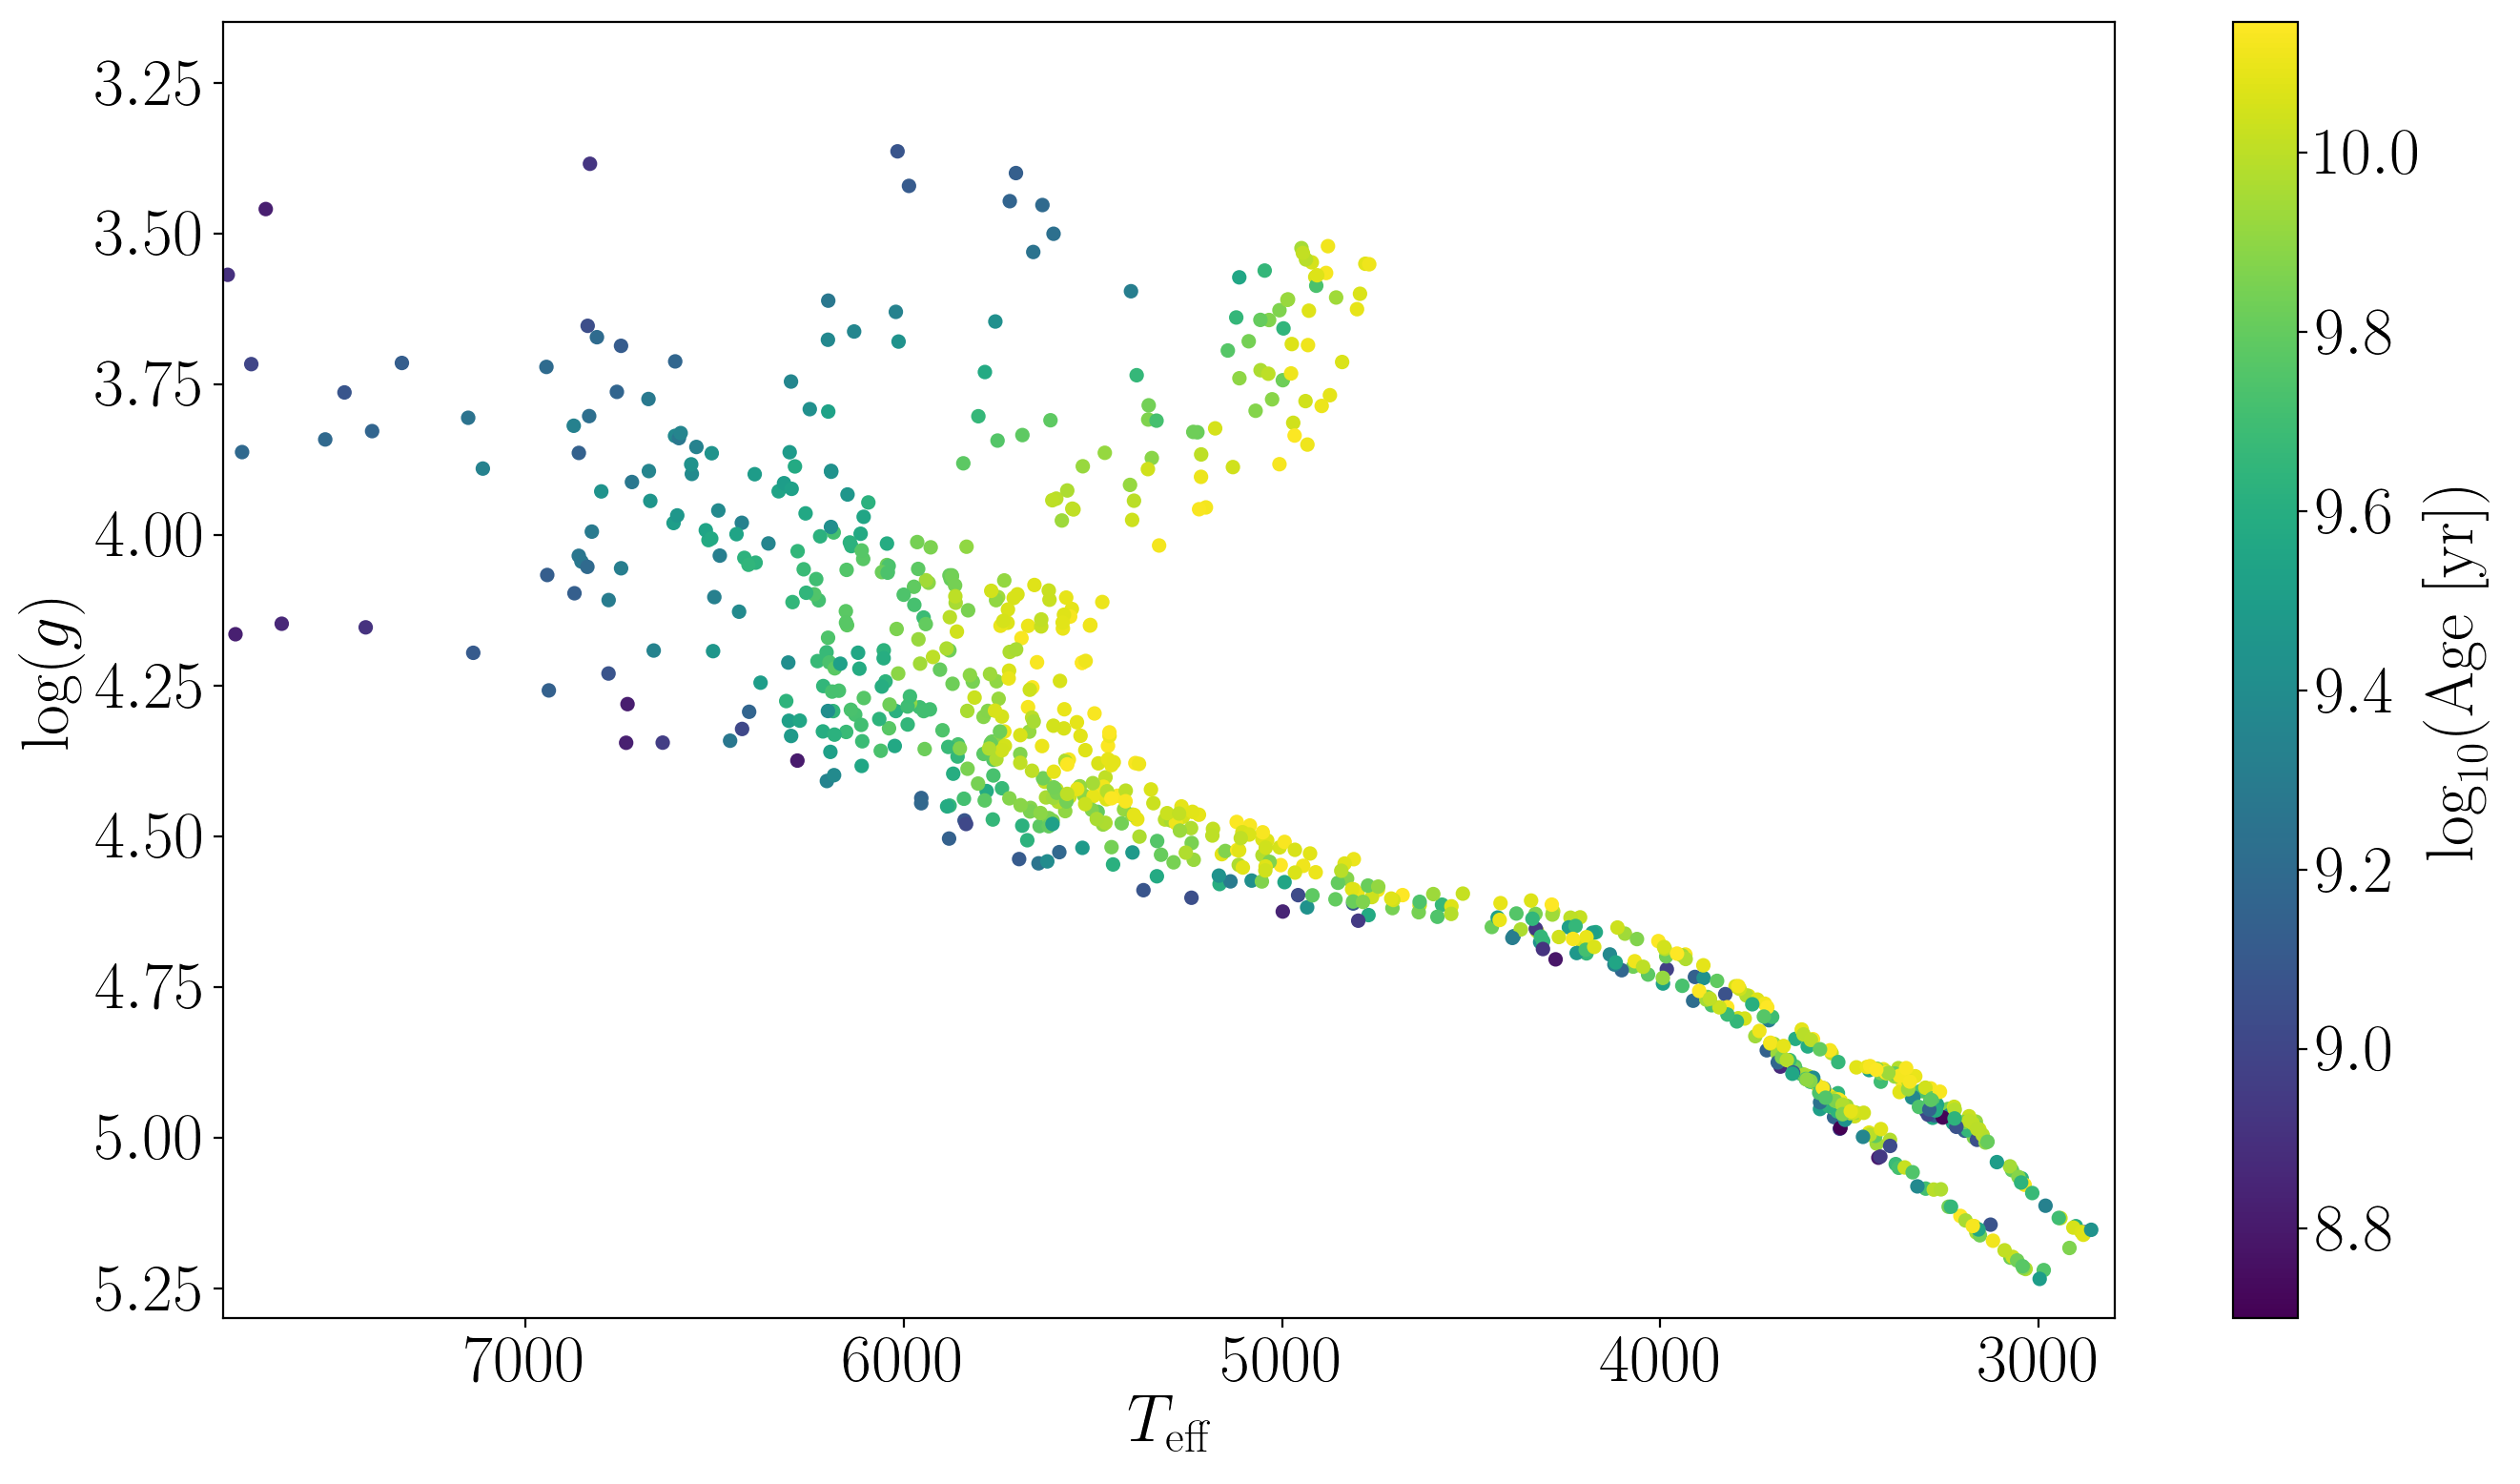

In [117]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(teff, logg, c=age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and B-V colours.

In [121]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

def convective_turnover_time(*args):
    """
    Estimate the convective overturn time using equation 11 in Wright et al.
    (2011): https://arxiv.org/abs/1109.4634
    log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)
    (I assume log is log10)
    params:
    ------
    EITHER:
    mass: (float)
        Mass in Solar units
    OR
    eep: (float)
        The Equivalent evolutionary point of a star. 355 for the Sun.
    age: (float)
        The age of a star in log_10(years).
    feh: (float)
        The metallicity of a star.
    """

    if len(args) > 1:
        # Convert eep, age and feh to mass (mass will be in Solar mass units)
        eep, age, feh = args
        M = mist.mass(eep, age, feh)
    else:
        M = args[0]

    log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
    return 10**log_tau


def gyro_model_rossby(mass, log10_age, bv, Ro_cutoff=2.16):
    """
    For a given mass, what is the final period, ie what is the period for Ro = 2.16?
    """
    age_myr = (10**log10_age)*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    
    pmax = Ro_cutoff * convective_turnover_time(mass)

    age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
    log10_age_thresh = np.log10(age_thresh_myr*1e6)
    
    if log10_age < log10_age_thresh:
        log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
        
    else:
        log_P = np.log10(pmax)
    return 10**log_P

print("Sun's rotation period = ", gyro_model_rossby(1., np.log10(4.67*1e9), 0.65))

Sun's rotation period =  25.322324757690506


Cut the hot stars and the subgiants.

In [106]:
# Calculate periods. NaNs will appear for stars with B-V < 0.45
prot = gyro_model_rossby(df.age, df.BV)

# random periods for cool stars.
cool_mask = df.BV > 1.6
prot[cool_mask] = 10**np.random.uniform(-.7, 1.5, len(prot[cool_mask]))

# # Random periods for hot stars.
# hot_mask = .45 > df.BV
# prot[hot_mask] = 10**np.random.uniform(-.7, 1.5, len(prot[hot_mask]))

# # Give the evolved stars randomly distributed rotation periods
# evolved_mask = df.eep > 454
# prot[evolved_mask] = 10**np.random.uniform(-.7, 1.5, len(prot[evolved_mask]))

df["prot"] = prot

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), len(df.mass.values[finite_mask]))

1000 864


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


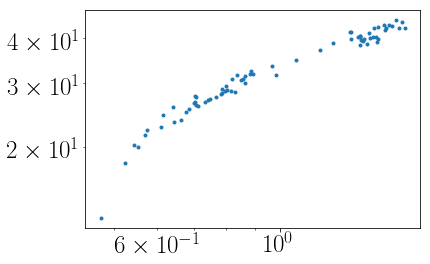

In [107]:
m = (df.age.values > np.log10(4*1e9)) * (np.log10(5*1e9) > df.age.values)
plt.loglog(df.BV[m], df.prot[m], ".")

Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

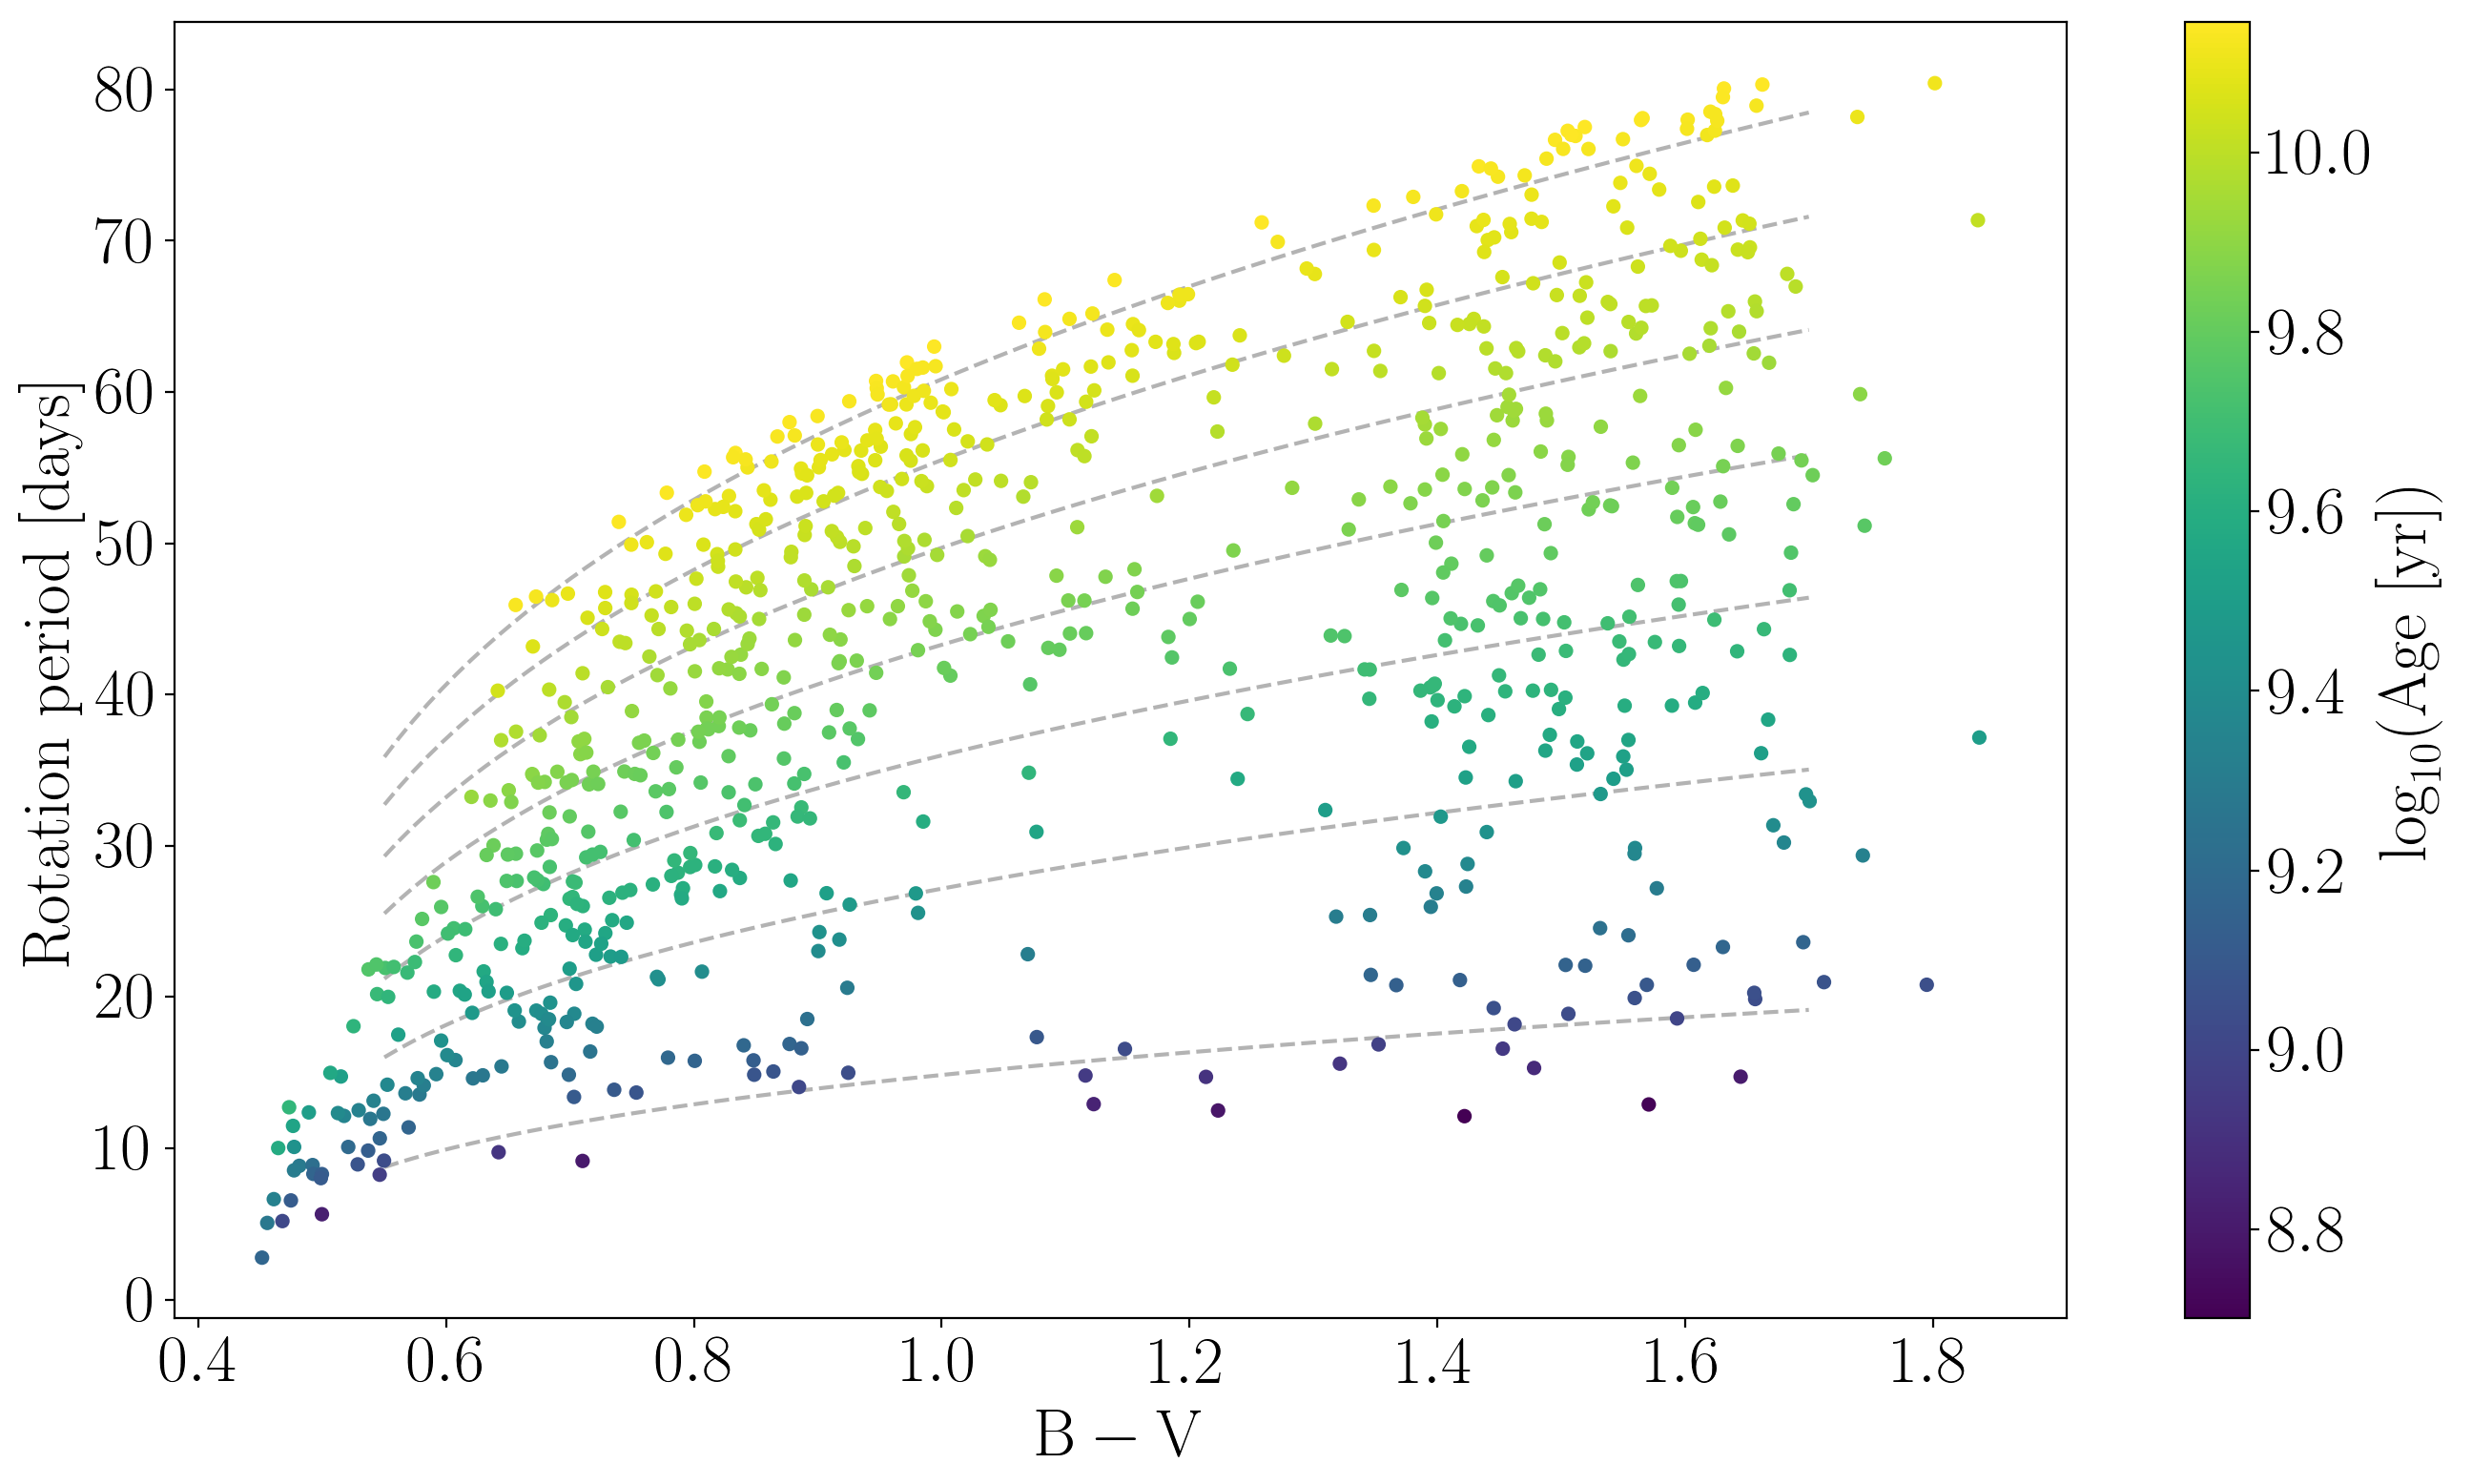

In [108]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=20, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

In [109]:
# Find an evolved star
print(df.eep.values[evolved_mask][0])
print(df.prot.values[evolved_mask][0])
print((10**df.age.values[evolved_mask][0])*1e-9)
print(df.BV.values[evolved_mask][0])
print(gyro_rot(df.age.values[evolved_mask][0], df.BV.values[evolved_mask][0]))
print(gyro_age(df.prot.values[evolved_mask][0], df.BV.values[evolved_mask][0]))

382.75325951255445
48.450838176763824
10.75187654264249
0.8194025216202601
48.450838176763824
10.031484268995005


In [110]:
print(df.iloc[0])

Av             0.393636
Av_err         0.010000
age            9.605631
age_err        1.921126
d_kpc          0.576276
dkpc_err       0.057628
eep          247.762885
eep_err        0.100000
feh            0.069081
feh_err        0.010000
BV             1.498253
B             23.042871
V             21.544618
jmag          17.031441
hmag          16.355823
kmag          16.116985
logg           4.972144
teff        3228.128205
logL          -2.108388
parallax       1.735280
mass           0.273504
prot          39.039257
Name: 0, dtype: float64


Test whether a stars meets the gyro criteria.

In [111]:
from stardate.lhf import convective_overturn_time

def test_gyro_is_on(bv, eep, age, feh, prot):
    tau = convective_overturn_time(eep, age, feh)
    if bv < .45:
        print("too hot")
        return False, prot/tau, (10**gyro_age(prot, bv))*1e-9
    if eep > 454:
        print("Evolved")
        return False, prot/tau, (10**gyro_age(prot, bv))*1e-9
    if prot/tau > 2.16:
        print("Rossby number is too high")
        return False, prot/tau, (10**gyro_age(prot, bv))*1e-9
    else:
        print("Suitable for gyro")
        return True, prot/tau, (10**gyro_age(prot, bv))*1e-9

# print(test_gyro_is_on(.65, 355, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.4, 355, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.65, 460, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.65, 355, np.log10(4.56*1e9), 0., 35))

i = 0
print(df.B[i] - df.V[i], df.eep[i], (10**df.age[i])*1e-9, df.feh[i], df.prot[i])
status, Ro, gage = test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i])
print(status, Ro, gage, "\n")

i = 1
print(df.B[i] - df.V[i], df.eep[i], (10**df.age[i])*1e-9, df.feh[i], df.prot[i])
status, Ro, gage = test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i])
print(status, Ro, gage, "\n")

i = 2
print(df.B[i] - df.V[i], df.eep[i], (10**df.age[i])*1e-9, df.feh[i], df.prot[i])
status, Ro, gage = test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i])
print(status, Ro, gage, "\n")

1.4982525816889236 247.7628847190066 4.033026730434735 0.06908119768355919 39.03925652094702
Suitable for gyro
True 0.5804467804873317 4.033026730434735 

0.7895028082616538 349.4417700028321 3.8342137874719997 0.11867255887654893 26.769694490778413
Suitable for gyro
True 1.9560443078126315 3.8342137874719997 

0.8999716560880362 443.7895632247764 12.734436837034004 -0.09981284048300042 56.53094551802491
Rossby number is too high
False 3.3074820581611477 12.734436837034004 



Save simulated data file.

In [112]:
finite_df.to_csv("data/simulated_data.csv")

Text(0.5,0,'$\\mathrm{Mass~}[M_\\odot]$')

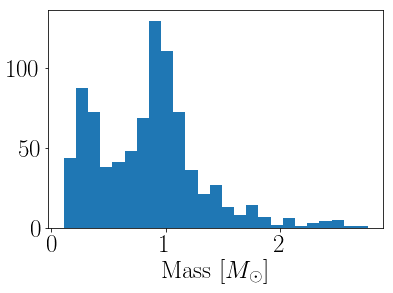

In [113]:
plt.hist(finite_df.mass, 25);
plt.xlabel("$\mathrm{Mass~}[M_\odot]$")

In [27]:
# iso = read_mist_models.ISO("data/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

# tmin, tmax = 3500, 7000
# Lmin, Lmax = -1.2, 1

# teffs, Ls, ages, eeps = [[] for i in range(4)]
# for i, a in enumerate(tqdm(np.log10(np.linspace(.1, 13.8, 100)*1e9))):

#     age_ind = iso.age_index(a) #returns the index for the desired age
#     logTeff = iso.isos[age_ind]['log_Teff']
#     logL = iso.isos[age_ind]['log_L']
#     eep = iso.isos[age_ind]['EEP']
#     age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
    
#     teff = 10**logTeff

#     m = (teff < tmax) * (tmin < teff)
#     m &= (logL < Lmax) * (Lmin < logL)

#     Ls.append(logL[m])
#     teffs.append(teff[m])
#     ages.append(age[m])
#     eeps.append(eep[m])
   
# teffs = np.array([i for j in teffs for i in j])
# Ls = np.array([i for j in Ls for i in j])
# ages = np.array([i for j in ages for i in j])
# eeps = np.array([i for j in eeps for i in j])